In [1]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score

np.random.seed(252525)
torch.manual_seed(252525)


SyntaxError: unmatched ')' (mvtec.py, line 15)

In [326]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 4)

    def forward(self, x):
        out = self.features(x)
        self.fmaps = out.detach()
        out = out.view(out.size(0), -1)        
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

# test()


def Transpose2(x, axis=2):
    return x.transpose(axis)

def Transpose1(x, axis=1):
    return x.transpose(axis)

def Id(x):
    return x


class RandomRot():
    
    def __init__(self, idx=None):
        self.idx = idx

    def __call__(self, x):
        if type(x) == int:
            # This works because ``transforms``` is called before ``target_transform`` in ``torch.Datasets``
            return self.label
        
        rot = [Id, # 0
              transforms.Compose([Transpose2, transforms.RandomHorizontalFlip(1.0), transforms.RandomVerticalFlip(1.0)]), # 90
              transforms.Compose([Transpose1, transforms.RandomHorizontalFlip(1.)]), # 180 
              transforms.Compose([transforms.RandomHorizontalFlip(1.), Transpose2, transforms.RandomVerticalFlip(1.)])   # 270
             ]                                     
        self.label =  np.random.randint(4) if self.idx is None else self.idx
        return rot[self.label](x)

In [327]:
def compute_logits(dataloader):
    net.eval()
    outputs, targets = [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets_) in enumerate(dataloader):

            inputs, targets_ = inputs.to(device), targets_.to(device)
            outputs_ = net(inputs).detach().cpu()
            outputs.append(outputs_)
            targets.append(targets_)
    
    return torch.cat(outputs, dim=0), torch.cat(targets, dim=0)

def compute_features(dataloader):
    net.eval()
    outputs, targets = [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets_) in enumerate(dataloader):

            inputs, targets_ = inputs.to(device), targets_.to(device)
            outputs_ = net(inputs).detach().cpu()
            outputs.append(net.fmaps)
            targets.append(targets_)
    
    return torch.cat(outputs, dim=0), torch.cat(targets, dim=0)


In [502]:
def compute_scores(logits):
    
    softmax = torch.softmax(logits, dim=2)
    
    sum_softmax =  softmax[0, :,  0]
    sum_softmax += softmax[1, :,  1]
    sum_softmax += softmax[2, :,  2]
    sum_softmax += softmax[3, :,  3]
    
    return -sum_softmax

def compute_scores_ica(ica_features):
    
    norm = np.linalg.norm(ica_features, ord=2.0, axis=2)
    return norm.mean(0)

scores = compute_scores(logits)
scores = compute_scores_ica(ica_features)
roc_auc_score(binary_labels, scores)

0.5633903333333333

In [505]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

aucs = []

for base in range(2,10):

    randomRot = RandomRot()

    # Data
    print('==> Preparing data..')
    transform_train = transforms.Compose([
    #    transforms.RandomCrop(32, padding=4),
    #    transforms.RandomHorizontalFlip(),
         randomRot,
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        randomRot,
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset_ = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=None, target_transform=None)
    inliers = [i for i,(d,l) in enumerate(trainset_) if l == base]      
    trainset = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=transform_train, target_transform=randomRot)
    trainset = torch.utils.data.Subset(trainset, inliers)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

    testset_ = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None, target_transform=None)
    inliers = [i for i,(d,l) in enumerate(testset_) if l == base] 
    testset = torchvision.datasets.CIFAR10( root='./data', train=False, download=True, transform=transform_test, target_transform=randomRot)
    testset = torch.utils.data.Subset(testset, inliers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    ensemble = []
    for ensemble_idx in range(1):
    
        # Model
        print('==> Building model..')
        net = VGG('VGG19')
        net = net.to(device)
        ensemble.append(net)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

        # Training
        def train(epoch):
            print('\nEpoch: %d' % epoch)
            net.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


        def test(epoch):
            global best_acc
            net.eval()
            test_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, targets)

                    test_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()

                print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

            if False:
                # Save checkpoint.
                acc = 100.*correct/total
                if acc > best_acc:
                    print('Saving..')
                    state = {
                        'net': net.state_dict(),
                        'acc': acc,
                        'epoch': epoch,
                    }
                    if not os.path.isdir('checkpoint'):
                        os.mkdir('checkpoint')
                    torch.save(state, './checkpoint/ckpt.pth')
                    best_acc = acc

        for epoch in range(start_epoch, start_epoch+30):
            train(epoch)
            test(epoch)
            scheduler.step()
        
    #
    # TESTTIME
    #

    features1, rot_labels1 = compute_features(trainloader)
    features2, rot_labels2 = compute_features(trainloader)
    features = torch.cat([features1, features2])
    rot_labels = torch.cat([rot_labels1, rot_labels2])
    
    features = features.cpu().numpy().reshape(10000, 512)
    rot_labels = rot_labels.cpu().numpy()
    
    ica = FastICA(n_components=10, whiten=True, max_iter=5000).fit(features)
    
    ica_features, logits, labels = [], [], []

    for rot in range(4):

        trans = transforms.Compose([
            RandomRot(rot),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        ## LOGITS
        testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=trans, target_transform=None)

        testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False)

        logits_, labels = compute_logits(testloader)

        ## ICA
        # ica = FastICA(n_components=1, whiten=True, max_iter=5000).fit(features[rot_labels == rot])
        ica_features_train_ = ica.transform(features[rot_labels == rot])

        features_, _ = compute_features(testloader)
        features_ = features_.cpu().numpy().reshape(10000, 512)
        ica_features_ =  ica.transform(features_)
        ica_features_ = ica_features_ - ica_features_train_.mean(0)
        
        ica_features.append(ica_features_)
        logits.append(logits_)


    binary_labels = np.zeros(len(labels))
    binary_labels[labels.cpu() != base] = 1
    binary_labels[labels.cpu() == base] = 0

    logits = torch.stack(logits)
    ica_features = np.stack(ica_features)

    scores = compute_scores(logits).cpu().numpy()
    auc_logit = roc_auc_score(binary_labels, scores)

    scores = compute_scores_ica(ica_features)
    auc_ica = roc_auc_score(binary_labels, scores)


    aucs.append( (auc_logit, auc_ica) ) 

    print("Base:", base, "AUC", aucs[-1])
    break

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
39 40 Loss: 1.396 | Acc: 32.180% (1609/5000)
9 10 Loss: 1.397 | Acc: 28.400% (284/1000)

Epoch: 1
39 40 Loss: 1.260 | Acc: 42.960% (2148/5000)
9 10 Loss: 1.284 | Acc: 44.900% (449/1000)

Epoch: 2
39 40 Loss: 1.148 | Acc: 51.000% (2550/5000)
9 10 Loss: 1.160 | Acc: 50.300% (503/1000)

Epoch: 3
39 40 Loss: 1.050 | Acc: 55.500% (2775/5000)
9 10 Loss: 1.150 | Acc: 51.200% (512/1000)

Epoch: 4
39 40 Loss: 0.953 | Acc: 62.340% (3117/5000)
9 10 Loss: 1.155 | Acc: 52.900% (529/1000)

Epoch: 5
39 40 Loss: 0.915 | Acc: 64.360% (3218/5000)
9 10 Loss: 0.992 | Acc: 58.600% (586/1000)

Epoch: 6
39 40 Loss: 0.849 | Acc: 67.060% (3353/5000)
9 10 Loss: 1.102 | Acc: 55.900% (559/1000)

Epoch: 7
39 40 Loss: 0.780 | Acc: 70.420% (3521/5000)
9 10 Loss: 0.984 | Acc: 62.300% (623/1000)

Epoch: 8
39 40 Loss: 

In [324]:
pd.DataFrame(aucs + [np.asarray(aucs).mean(0)], list(classes) + ["mean"])

,0
plane,0.742162
car,0.905145
bird,0.712020
cat,0.683071
deer,0.738190
dog,0.792746
frog,0.772022
horse,0.915538
ship,0.910199
truck,0.876733


In [365]:
Xrepeatdded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(features.reshape(4*10000, 512).cpu().numpy())
X_embedded.shape

(40000, 2)

Text(0.5, 1.0, 'Last layer feature space (T-SNE)')

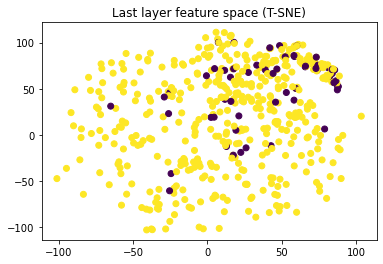

In [372]:
plt.scatter(X_embedded[:500, 0], X_embedded[:500, 1], c= np.tile(binary_labels, 4)[:500])
plt.title("Last layer feature space (T-SNE)")

Text(0.5, 1.0, 'Last layer feature space (T-SNE): Outliers, colors are classes')

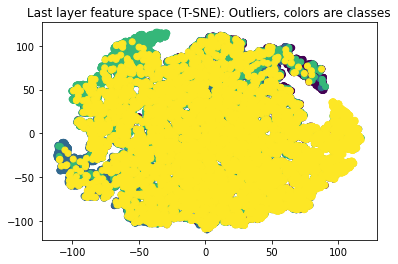

In [388]:
all_labels = np.tile(labels.cpu().numpy(), 4)

plt.scatter(X_embedded[:, 0][all_labels != base], X_embedded[:, 1][all_labels != base], c= np.repeat([0,1,2,3], 10000)[all_labels != base])
plt.title("Last layer feature space (T-SNE): Outliers, colors are classes")

Text(0.5, 1.0, 'Last layer feature space (T-SNE): Inliers, colors are classes')

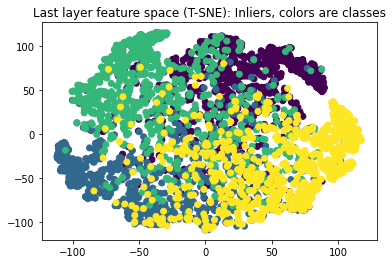

In [387]:
all_labels = np.tile(labels.cpu().numpy(), 4)

plt.scatter(X_embedded[:, 0][all_labels == base], X_embedded[:, 1][all_labels == base], c= np.repeat([0,1,2,3], 10000)[all_labels == base])
plt.title("Last layer feature space (T-SNE): Inliers, colors are classes")

In [407]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(ica_features.reshape(4*10000, 3))
X_embedded.shape

(40000, 2)

Text(0.5, 1.0, 'Last layer feature space (T-SNE)')

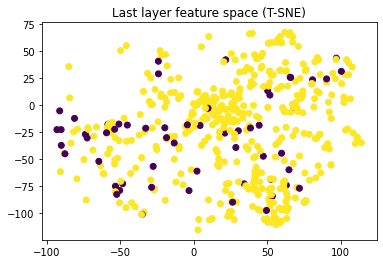

In [408]:
plt.scatter(X_embedded[:500, 0], X_embedded[:500, 1], c= np.tile(binary_labels, 4)[:500])
plt.title("Last layer feature space (T-SNE)")

Text(0.5, 1.0, 'Last layer feature space (T-SNE): Outliers, colors are classes')

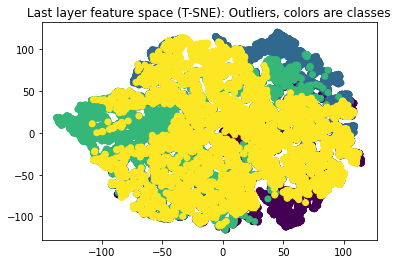

In [409]:
all_labels = np.tile(labels.cpu().numpy(), 4)

plt.scatter(X_embedded[:, 0][all_labels != base], X_embedded[:, 1][all_labels != base], c= np.repeat([0,1,2,3], 10000)[all_labels != base])
plt.title("Last layer feature space (T-SNE): Outliers, colors are classes")

Text(0.5, 1.0, 'Last layer feature space (T-SNE): Inliers, colors are classes')

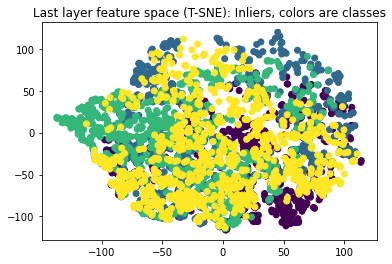

In [410]:
all_labels = np.tile(labels.cpu().numpy(), 4)

plt.scatter(X_embedded[:, 0][all_labels == base], X_embedded[:, 1][all_labels == base], c= np.repeat([0,1,2,3], 10000)[all_labels == base])
plt.title("Last layer feature space (T-SNE): Inliers, colors are classes")